[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SaberaTalukder/Chen_Institute_DataSAI_for_Neuroscience/blob/main/07_06_22_day2_dynamical_time_series/code/solutions/neural_model_simulation_solutions.ipynb)

# Background concepts
A neuron can be thought of as a bubble that isolates its internal environment from its surroundings. By expressing an assortment of channels in its membrane, it can transport ions and molecules across the bubble wall, at the cost of some energy. The resulting concentration and charge gradient across the cell membrane is a store of potential energy that the cell can take advantage of to do interesting things- like fire action potentials.

### What is a reversal potential?
The resting membrane potential of a neuron is determined by a finely tuned balance of ion conductances- predominantly sodium (Na+), potassium (K+), chloride (Cl-), and calcium (Ca2+). In the absence of any external input, each ion experiences two competing "forces" across the cell's membrane: a chemical force that tries to equilize the concentration of the ion inside vs outside of the membrane, and an electrical force that tries to equilize charges inside vs outside the membrane. Neurons also posess a collection of "ion pumps" that transport charged ions across the cell membrane in a way that maintains a concentration differential inside vs outside of the cell.

The **[Nernst Equilibrium Potential](https://www.physiologyweb.com/lecture_notes/resting_membrane_potential/resting_membrane_potential_nernst_equilibrium_potential.html)**, or **reversal potential**, is balance of these two forces, aka the net charge difference (or voltage) across the cell membrane at which concentration and charge forces on a given ion are balanced.

### What is a conductance?
Conductance is simply defined as 1/resistance, meaning it is a measure of how easy it is for charge to flow from one point to another. In neuroscience, we often measure the conductance of different ions across the cell membrane. Neurons produce specialized ion channels that allow specific ions to pass through them, entering from the outside to the inside of the cell (or vice versa). The more ion channels there are in the membrane, the more ions can flow through it, and thus the higher the membrane conductance for that ion. Some ion channels are "gated", meaning that they only allow the flow of ions in certain conditions: these allow neurons to switch from a low to a high ion conductance when certain conditions are met.

![ion_channel.jpg](https://drive.google.com/uc?export=view&id=1GKS1BynnRm2odGRuCwS6LUIAHFuPcXXk)

### What happens during an action potential?
An action potential is the magic of gated ion channels in action. Specifically, neurons have a population of *voltage-gated* ion channels, that open and close as a function of the difference in charge across the cell membrane (what is called the *membrane potential*.)

Any single ion channel is only going to be open or closed at a given time, but as a *population*, the proportion of open channels for a particular ion will evolve as a function of time and membrane potential. During an action potential, a series of voltage-gated channels for various ions open and close in a particular order, causing a rapid depolarization of the neuron followed by a repolarization stage that brings things back to the cell's resting potential.

Hodgkin and Huxley built a model of how the membrane potential of a squid giant axon evolves following an injection of current- seen below, the top plot is the membrane potential (showing two action potentials), and the bottom row is the current injection.
![source: https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hodgkin-huxley.html](https://drive.google.com/uc?export=view&id=1AoJD2snOLCFJXcQHeO1ZIlB490Xhdhmv)([source](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hodgkin-huxley.html))

The three lines in the middle plot represent the activations of three intervening parameters: H&H didn't know it at the time, but these very closely capture the opening and closing dynamics of ion channels in the cell membrane. It is these time-evolving signals that collectively give rise to the fluctionations of the neuron membrane potential in the top trace.

# The Morris-Lecar model
Most neuroscientists know the story of the [Hodgkin Huxley model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) and the squid giant axon. But  you can get nearly the same range of spiking behaviors with half the parameters: enter the **Morris-Lecar model**, one of the most popular conductance-based models in neuroscience.

Developed by Catherine Morris and Harold Lecar from recordings of the [giant acorn barnacle](https://en.wikipedia.org/wiki/Balanus_nubilus), this model captures the spiking dynamics of neurons in terms of two dynamical parameters: a membrane potential $V$ and a recovery variable $W$, the latter of which captures the fraction of open potassium ion channels in the neuron.

Because potassium ion channels open/close more slowly than other voltage-gated channels, they become a rate-limiting step for action potentials; by comparison, all other ion channels can be assumed to achieve their steady-state values instantaneously. This separation of timescales is what allows Morris and Lecar to describe the entire action potential generation process in terms of only two parameters.

[Read more about the Morris-Lecar model on Scholarpedia](http://www.scholarpedia.org/article/Morris-Lecar_model).

[Read more about the Morris-Lecar model on Wikipedia](https://en.wikipedia.org/wiki/Morris%E2%80%93Lecar_model).

## Introducing the model

In this notebook, we're going to take a pre-written simulation of the Morris-Lecar model and play around with it to see what it does. The Morris-Lecar model is defined by the following pair of diffential equations:

\begin{align}
  C \frac{dV}{dt} & ~=~ - g_\mathrm{Ca} M_\mathrm{ss}(V) (V-V_\mathrm{Ca}) - g_\mathrm{K} W (V-V_\mathrm{K}) - g_\mathrm{L} (V-V_\mathrm{L}) + I\\[5pt]
  \frac{dW}{dt} & ~=~ \frac{W_\mathrm{ss}-W}{T_\mathrm{W}(V)}
\end{align}

Let's start with the biophysical parameters: $C$ is the membrane capacitance, $g_\mathrm{Ca}$, $g_\mathrm{K}$, and $g_\mathrm{L}$ are ion-specific conductances ("L" is a leak conductance, basically a catch-all for all ions other than potassium and calcium), and $V_\mathrm{Ca}$, $V_\mathrm{K}$, and $V_\mathrm{L}$ are corresponding ion-specific reversal potentials.

The dynamics of voltage-gated ion channels are captured by $M_\mathrm{ss}(V)$ and $W$, describing how calcium and potassium conductances change as a function of the membrane potential $V$. $M_\mathrm{ss}(V)$ is called that because it is fast compared to $W$, effectively instantly reaching its *steady-state* value (hence the *ss*).

$W$ evolves more slowly- the second equation shows the dynamics by which it reaches its steady-state value $W_\mathrm{ss}(V)$ as a function of time. Our remaining parameter $T_\mathrm{W}(V)$ captures just that, the membrane-potential-dependent-rate at which $W$ approaches $W_\mathrm{ss}$.

Now for the last bit of equations- we have to define $M_\mathrm{ss}(V)$, $W_\mathrm{ss}(V)$, and $T_\mathrm{W}(V)$. These are defined in terms of five parameters that Morris and Lecar fit to their data:

\begin{align}
M_\mathrm{ss}(V) & ~=~ (1 + \tanh[(V-V_1)/V_2])/2\\
W_\mathrm{ss}(V) & ~=~ (1 + \tanh[(V-V_3)/V_4])/2\\
T_\mathrm{W}(V) & ~=~ 1/\cosh[(V-V_3)/(2V_4)]\\
\end{align}

## Understanding the channel steady-state dynamics

Before we go further, let's quickly look at how these last three equations change as a function of V:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Here's a quick implementation of each equation. We'll use V1-V4 values derived from data.

In [ ]:
V1 = -1.2
V2 = 18.0
V3 = 12.0
V4 = 17.4

Mss = lambda V: (1 + np.tanh((V - V1)/V2))/2.   # steady-state solution for the voltage-sensitive calcium conductance
Wss = lambda V: (1 + np.tanh((V - V3)/V4))/2.   # steady-state solution for the slow voltage-sensitive potassium conductance
Tw  = lambda V: 1./ np.cosh((V - V3)/(2.*V4))   # recovery rate of potassium channel relaxation

In [ ]:
# Now, plot the value of each parameter over a biologically reasonable range of membrane potentials.


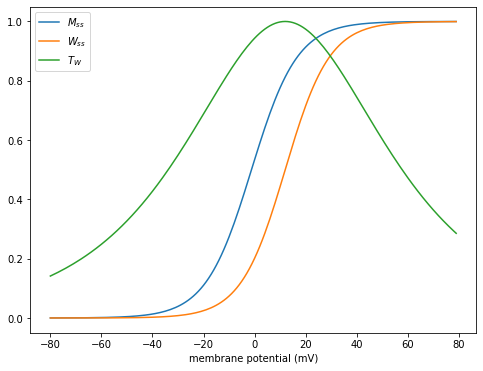

In [ ]:
# solution

plt.subplots(figsize=(8,6))
V_ran = np.arange(-80,80)
plt.plot(V_ran, Mss(V_ran), label='$M_{ss}$')
plt.plot(V_ran, Wss(V_ran), label='$W_{ss}$')
plt.plot(V_ran, Tw(V_ran), label='$T_{W}$')
plt.xlabel('membrane potential (mV)')
plt.legend()
plt.show()

$M_\mathrm{ss}$ and $W_\mathrm{ss}$ are telling us that as the membrane potential increases, the calcium and potassium channels switch from being entirely shut (values at 0) to entirely open (values at 1); for intermediate voltages, only a fraction of channels will be open at any given time.

$T_\mathrm{W}$ is telling us that $W$ will approach its steady state value more slowly when the membrane potential is around 0, and will change more quickly when membrane potential is very low or very high.

So now about those mysterious $V_1$ - $V_4$ parameters- what are they doing? Try either looking at the equations or fiddling around with the values of these parameters, to determine the effect they are having on $M_\mathrm{ss}(V)$ and $W_\mathrm{ss}(V)$.

In [ ]:
# V1 and V3 ...
# V2 and V4 ...

In [ ]:
# Solution

# V1 and V3 adjust the center point of the tanh curve (when channels are 50% open)
# V2 and V4 adjust the slope (over what range of V channels flip from closed to open)

## Setting model parameters
We have two sets of parameters for the Morris-Lecar model: basic electrical properties of the cell, and voltage sensitivities and reaction times of the ion channels.

The first set of parameters are pretty consistent across neurons. Here are some reasonable values:

In [ ]:
param_cell = {'membrane_capacitance':         20.0,   # uF/cm^2
              
              'calcium_reversal_potential':   120.0,  # mV
              'potassium_reversal_potential': -80.0,  # mV
              'leak_reversal_potential':      -60.0,  # mV
              
              'calcium_conductance':          4.4,    # mS/cm^2
              'potassium_conductance':        8.0,    # mS/cm^2
              'leak conductance':             2.0,    # mS/cm^2
             }

The second set of ion channel parameters are different for different cell types. Here's one set of values to get you started:

In [ ]:
param_channels = {'V1': -1.2,   # mV
                  'V2': 18.0,   # mV
                  'V3': 12.0,   # mV
                  'V4': 17.4,   # mV
                  'T0': 0.0667  # ms^-1 we didn't talk about this- it's just another scaling term on the rate of change of W
                 }

And here is code that will numerically simulate one timestep of the model:

In [ ]:
def morris_lecar_step(V, W, param_cell, param_channels, I, dt):
    
    C   = param_cell['membrane_capacitance']
    gCa = param_cell['calcium_conductance']
    gK  = param_cell['potassium_conductance']
    gL  = param_cell['leak conductance']
    vCa = param_cell['calcium_reversal_potential']
    vK  = param_cell['potassium_reversal_potential']
    vL  = param_cell['leak_reversal_potential']
    
    V1  = param_channels['V1']
    V2  = param_channels['V2']
    V3  = param_channels['V3']
    V4  = param_channels['V4']
    T0  = param_channels['T0']
    
    Mss = lambda V: (1 + np.tanh((V - V1)/V2))/2.   # steady-state solution for the voltage-sensitive calcium conductance
    Wss = lambda V: (1 + np.tanh((V - V3)/V4))/2.   # steady-state solution for the slow voltage-sensitive potassium conductance
    Tw  = lambda V: 1./ np.cosh((V - V3)/(2.*V4))  # recovery rate of potassium channel relaxation
    
    
    # calculate change in V and W according to the Morris-Lecar model:
    dvdt = (1/C) * (-gCa * Mss(V)*(V - vCa) - gK * W * (V - vK) - gL * (V - vL) + I)
    dwdt = T0 * (Wss(V) - W)/Tw(V)
    
    # update V and W based on the model (Euler's method):
    V2 = V + dvdt * dt
    W2 = W + dwdt * dt
    
    return V2, W2, Mss(V), Wss(V), Tw(V)

## Running the simulation

Now it is time for science. To start, let's simulate the response of the model neuron to a one-second current injection. Complete this code snippet to simulate two seconds of the dynamics of the Morris-Lecar model, and plot V and W as functions of time.

In [ ]:
V = -60.0     # initial conditions for membrane potential and potassium conductance
W = 0.0

tmax = 2000.  # simulation time in milliseconds
dt = 0.1      # simulation timestep in milliseconds

stim_on = 0.1        # stimulus onset time in seconds
stim_duration = 1.   # stimulus duration in seconds
stim_amp = 60.0      # stimulus amplitude in uA

time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
I = [stim_amp if (t > stim_on and t <= (stim_on+stim_duration)) else 0 for t in time] # create our input current!
time = time - stim_on  # align time to current onset, just for fun
simtime = len(time)    # compute the number of simulation timesteps

v_store = np.zeros(simtime)  # store history of V
w_store = np.zeros(simtime)  # store history of W
for t in range(simtime):
    pass # replace this with your code

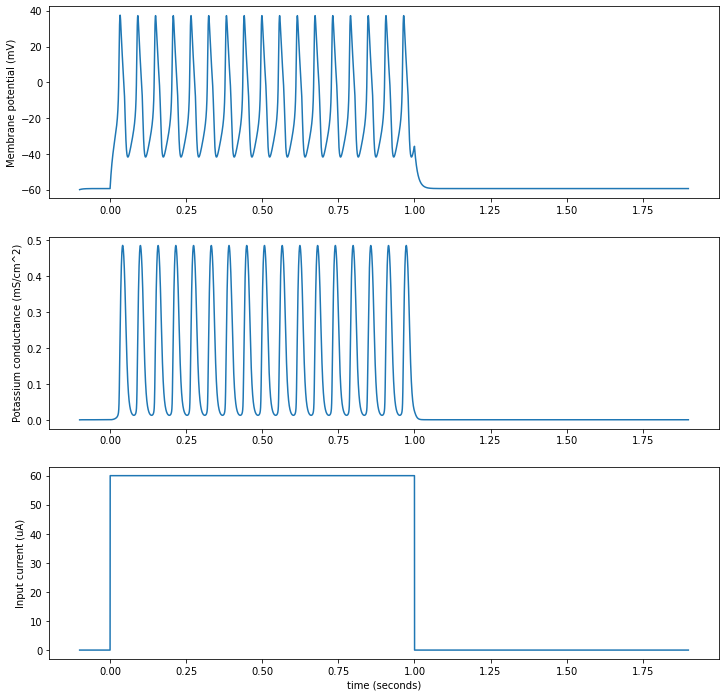

In [ ]:
# solution

V = -60.0     # initial conditions for membrane potential and potassium conductance
W = 0.0

tmax = 2000.  # simulation time in milliseconds
dt = 0.1      # simulation timestep in milliseconds

stim_on = 0.1        # stimulus onset time in seconds
stim_duration = 1.   # stimulus duration in seconds
stim_amp = 60.0      # stimulus amplitude in uA

time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
I = [stim_amp if (t > stim_on and t <= (stim_on+stim_duration)) else 0 for t in time] # create our input current!
time = time - stim_on  # align time to current onset, just for fun
simtime = len(time)    # compute the number of simulation timesteps

v_store = np.zeros(simtime)  # store history of V
w_store = np.zeros(simtime)  # store history of W
for t in range(simtime):
    V, W, _, _, _ = morris_lecar_step(V, W, param_cell, param_channels, I[t], dt)
    v_store[t] = V
    w_store[t] = W

fig, ax = plt.subplots(3, figsize=(12,12))
ax[0].plot(time, v_store)
ax[0].set_ylabel('Membrane potential (mV)')

ax[1].plot(time, w_store)
ax[1].set_ylabel('Potassium conductance (mS/cm^2)')

ax[2].plot(time, I)
ax[2].set_ylabel('Input current (uA)')
ax[2].set_xlabel('time (seconds)')
plt.show()

## F-I curves
A common analysis in neurophysiology is to plot the frequency-current (F-I) curve of a recorded neuron. To do so, you inject the cell with different amounts of current, and plot for each amount the cell's spiking frequency (in spikes/second).

Now that you have a working Morris-Lecar model, see if you can plot an F-I curve for the parameters you've been using! Try first using currents of up to $90 \mu A$.

After that, use the F-I curve to pick three values of $I$ and plot the model's response to a one-second input, to see what's going on as you increase I.

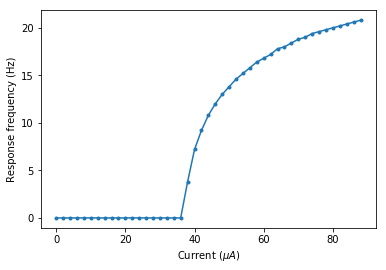

In [ ]:
# solution (takes a little while to run)

tmax = 5000.  # simulation time in milliseconds
dt = 0.1      # simulation timestep in milliseconds

stim_on = 0.1        # stimulus onset time in seconds
stim_duration = 5.   # stimulus duration in seconds


I_range = np.arange(0,90,2)
f_count = np.zeros(len(I_range))

for i, stim_amp in enumerate(I_range):  # stimulus amplitude in uA
    V = -60.0     # initial conditions for membrane potential and potassium conductance
    W = 0.0
    
    time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
    I = [stim_amp if (t > stim_on and t <= (stim_on+stim_duration)) else 0 for t in time] # create our input current!
    time = time - stim_on  # align time to current onset, just for fun
    simtime = len(time)    # compute the number of simulation timesteps

    v_store = np.zeros(simtime)  # store history of V
    f_count[i] = 0
    for t in range(simtime):
        V, W, _, _, _ = morris_lecar_step(V, W, param_cell, param_channels, I[t], dt)
        v_store[t] = V
        if t>0 and v_store[t]>0 and v_store[t-1]<=0:  # let's call crossing 0 our spiking threshold
            f_count[i] += 1.0/5.0  # spike rate is estimated over a 5-second window, so divide by 5 to get spikes/sec

plt.plot(I_range, f_count,'.-')
plt.xlabel('Current ($\mu A$)')
plt.ylabel('Response frequency (Hz)')
plt.show()

What happens to your spike rate if you go above $90 \mu A$? Why?

In [ ]:
# Above 90 uA, the spike rate...

In [ ]:
# Solution
# Above 90 uA, the spike rate drops off to zero, because the cell enters a tetanic phase where it no longer spikes :0

## Other behaviors of the Morris-Lecar model
If we change the channel activation parameters of the model, we can get it to act differently. Try making an F-I curve of the model using these other channel parameter settings, using an input range of $40 - 120 \mu A$.

As before, use the F-I curve to pick three values of $I$ and plot the model's response to a one-second input, to see what's going on in different regimes of the model.

In [ ]:
param_channels_2 = {'V1': -1.2,   # mV
                    'V2': 18.0,   # mV
                    'V3': 2.0,   # mV
                    'V4': 30.0,   # mV
                    'T0': 0.04  # ms^-1
                   }

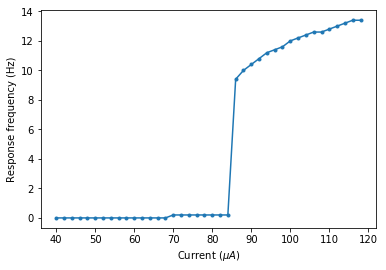

In [ ]:
# solution, plotting FI curve (takes a little while to run)

tmax = 5200.  # simulation time in milliseconds
dt = 0.1      # simulation timestep in milliseconds

stim_on = 0.1        # stimulus onset time in seconds
stim_duration = 5.   # stimulus duration in seconds

use_channel_type = param_channels_2


I_range = np.arange(40,120,2)
f_count = np.zeros(len(I_range))

for i, stim_amp in enumerate(I_range):  # stimulus amplitude in uA
    V = -60.0     # initial conditions for membrane potential and potassium conductance
    W = 0.0
    
    time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
    I = [stim_amp if (t > stim_on and t <= (stim_on+stim_duration)) else 0 for t in time] # create our input current!
    time = time - stim_on  # align time to current onset, just for fun
    simtime = len(time)    # compute the number of simulation timesteps

    v_store = np.zeros(simtime)  # store history of V
    f_count[i] = 0
    for t in range(simtime):
        V, W, _, _, _ = morris_lecar_step(V, W, param_cell, use_channel_type, I[t], dt)
        v_store[t] = V
        if t>0 and v_store[t]>0 and v_store[t-1]<=0:  # let's call crossing 0 our spiking threshold
            f_count[i] += 1.0/stim_duration  # divide by duration to get spikes/second

plt.plot(I_range, f_count,'.-')
plt.xlabel('Current ($\mu A$)')
plt.ylabel('Response frequency (Hz)')
plt.show()

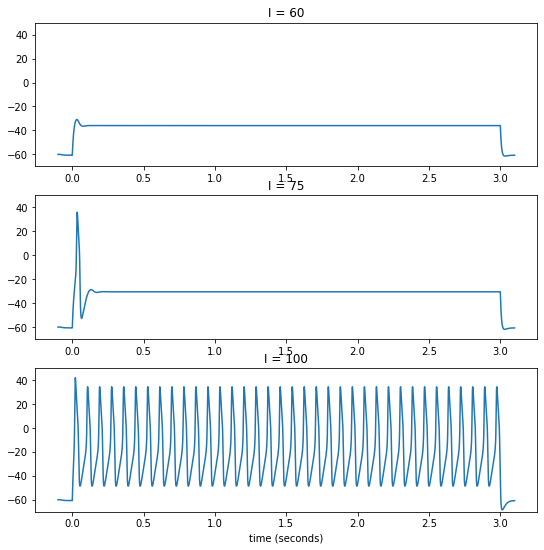

In [ ]:
# solution, checking values of I

tmax = 3200.  # simulation time in milliseconds
dt = 0.05      # simulation timestep in milliseconds

stim_on = 0.1        # stimulus onset time in seconds
stim_duration = 3.   # stimulus duration in seconds

use_channel_type = param_channels_2

fig,ax = plt.subplots(3,figsize=(9,9))
for i, stim_amp in enumerate([60, 75, 100]):  # stimulus amplitude in uA
    V = -60.0     # initial conditions for membrane potential and potassium conductance
    W = 0.0
    
    time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
    I = [stim_amp if (t > stim_on and t <= (stim_on+stim_duration)) else 0 for t in time] # create our input current!
    time = time - stim_on  # align time to current onset, just for fun
    simtime = len(time)    # compute the number of simulation timesteps

    v_store = np.zeros(simtime)  # store history of V
    for t in range(simtime):
        V, W, _, _, _ = morris_lecar_step(V, W, param_cell, use_channel_type, I[t], dt)
        v_store[t] = V

    ax[i].plot(time, v_store)
    ax[i].set_ylim([-70, 50])
    ax[i].set_title('I = ' + str(stim_amp))

ax[2].set_xlabel('time (seconds)')
plt.show()

## Phase portrait of the model
Extra-super bonus: try plotting $V$ and $W$ against each other for one of your simulations, alongside the nullclines for your two differential equations, for different values of your input $I$ and different channel parameter configurations.

What happens to the nullclines when your input current is big enough that the cell crosses your estimated spiking threshold?

What does the system trajectory in the phase portrait look like if you take a resting neuron and give it small, instantaneous current injections of various sizes?

Solution: The nullclines of a dynamical system are the lines along which the derivative of one variable is zero. Thus, you find them by taking your dynamics equations, setting $dx/dt=0$, and solving in terms of the remaining variables.

The equations for the Morris-Lecar model are:
\begin{align}
  C \frac{dV}{dt} & ~=~ - g_\mathrm{Ca} M_\mathrm{ss}(V) (V-V_\mathrm{Ca}) - g_\mathrm{K} W (V-V_\mathrm{K}) - g_\mathrm{L} (V-V_\mathrm{L}) + I\\[5pt]
  \frac{dW}{dt} & ~=~ \frac{W_\mathrm{ss}-W}{T_\mathrm{W}(V)}
\end{align}

so from setting $\frac{dW}{dt}=0$ we get one nullcline:
$$ W(V) = W_\mathrm{ss} = (1 + \tanh[(V-V_3)/V_4])/2$$
and from setting $\frac{dV}{dt}=0$ we get the other:
$$ W(V) = \frac{ - g_\mathrm{Ca} M_\mathrm{ss}(V) (V-V_\mathrm{Ca}) - g_\mathrm{L} (V-V_\mathrm{L}) + I}{g_\mathrm{K}(V-V_\mathrm{K})} $$

In [ ]:
def generate_nullclines(param_cell, param_channels):
  gCa = param_cell['calcium_conductance']
  gK  = param_cell['potassium_conductance']
  gL  = param_cell['leak conductance']
  vCa = param_cell['calcium_reversal_potential']
  vK  = param_cell['potassium_reversal_potential']
  vL  = param_cell['leak_reversal_potential']

  V1  = param_channels['V1']
  V2  = param_channels['V2']
  V3  = param_channels['V3']
  V4  = param_channels['V4']
  T0  = param_channels['T0']

  Mss = lambda V: (1 + np.tanh((V - V1)/V2))/2.   # steady-state solution for the voltage-sensitive calcium conductance
  Wss = lambda V: (1 + np.tanh((V - V3)/V4))/2.   # steady-state solution for the slow voltage-sensitive potassium conductance
  Tw  = lambda V: 1./ np.cosh((V - V3)/(2.*V4))   # recovery rate of potassium channel relaxation

  nullcline_1 = lambda V: (1 + np.tanh((V-V3)/V4))/2
  nullcline_2 = lambda V, I: (-gCa*Mss(V)*(V-vCa) - gL*(V - vL) + I)/(gK*(V - vK))
  
  return nullcline_1, nullcline_2

def ML_sim(param_cell, param_channels, stim_amp, tmax=1000., V0 = -60, W0 = 0):
  V = V0     # initial conditions
  W = W0

  dt = 0.1      # simulation timestep in milliseconds
  simtime = int(tmax/dt)    # compute the number of simulation timesteps
  time = np.arange(0, tmax, dt)/1000.  # simulation timestamps

  v_store = np.zeros(simtime)  # store history of V
  w_store = np.zeros(simtime)  # store history of W
  for t in range(simtime):
      V, W, _, _, _ = morris_lecar_step(V, W, param_cell, param_channels, stim_amp, dt)
      v_store[t] = V
      w_store[t] = W

  return v_store, w_store, time 

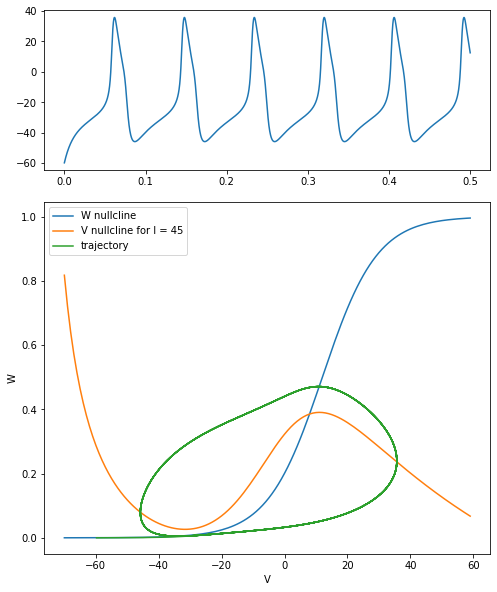

In [ ]:
fig = plt.figure(figsize=(8,10))
gs  = fig.add_gridspec(nrows=3, ncols=1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1:])

# pro tip: try doing this with param_channels vs param_channels_2
use_channelset = param_channels
nc1, nc2 = generate_nullclines(param_cell, use_channelset)

V_ran = np.arange(-70,60)
ax1.plot(V_ran, nc1(V_ran), label = 'W nullcline')

I = 45
ax1.plot(V_ran, nc2(V_ran, I), label = 'V nullcline for I = ' + str(I))
v,w,time = ML_sim(param_cell, use_channelset, I, tmax=500., V0 = -60, W0 = 0)
ax1.plot(v, w, label='trajectory')
ax0.plot(time,v)

ax1.set_xlabel('V')
ax1.set_ylabel('W')
ax1.legend()
plt.show()

## Simulation pragmatics
Our simulation code above snuck in an additional parameter: our time step dt. When we simulate our dynamical system using Euler's method, what we're really doing is looking at a first-order appoximation of how the system would behave.

So long as your simulation timestep is small relative to the time constants of your system, this is perfectly fine. but if your timestep is coarse, the dynamics you get from simulating and the true dynamics of the system diverge.

To see this, try simulating the Morris-Lecar model's response to a one-second, $60 \mu A$ input, for a range of values of `dt`. At what point does the simulation lose accuracy?

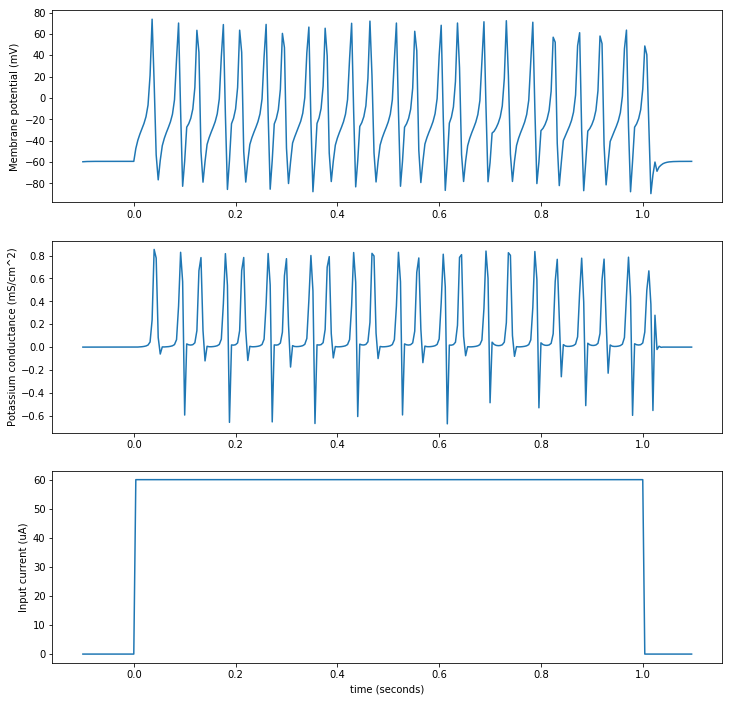

In [ ]:
# solution- here's a wonky looking simulation from bumping dt up to 4ms. If you go much higher than this you get numpy errors.

V = -60.0     # initial conditions for membrane potential and potassium conductance
W = 0.0

tmax = 1200.  # simulation time in milliseconds
dt = 4      # simulation timestep in milliseconds

stim_on = 0.1        # stimulus onset time in seconds
stim_duration = 1.   # stimulus duration in seconds
stim_amp = 60.0      # stimulus amplitude in uA

time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
I = [stim_amp if (t > stim_on and t <= (stim_on+stim_duration)) else 0 for t in time] # create our input current!
time = time - stim_on  # align time to current onset, just for fun
simtime = len(time)    # compute the number of simulation timesteps

v_store = np.zeros(simtime)  # store history of V
w_store = np.zeros(simtime)  # store history of W
for t in range(simtime):
    V, W, _, _, _ = morris_lecar_step(V, W, param_cell, param_channels, I[t], dt)
    v_store[t] = V
    w_store[t] = W

fig, ax = plt.subplots(3, figsize=(12,12))
ax[0].plot(time, v_store)
ax[0].set_ylabel('Membrane potential (mV)')

ax[1].plot(time, w_store)
ax[1].set_ylabel('Potassium conductance (mS/cm^2)')

ax[2].plot(time, I)
ax[2].set_ylabel('Input current (uA)')
ax[2].set_xlabel('time (seconds)')
plt.show()

#### Bonus round: thinking in matrix notation
We're always treating $V$ and $W$ as two separate variables, which is fine- but it can be a good mental exercise to try to think of how you could repackage this system using matrix notation.

Specifically: how could you re-write the Morris-Lecar equations for $V$ and $W$ in terms of a single vector $Y$, whose dynamics take the form:

\begin{align}
\frac{dy}{dt} & ~=~ A(y) - B(y) y
\end{align}

In [ ]:
# solution: see markdown cell below.

$
y =\begin{pmatrix} V \\ W \end{pmatrix}\\
$

$
A(y) = \begin{pmatrix} \frac{1}{C}(g_\mathrm{Ca} M_\mathrm{ss}(V)V_\mathrm{Ca} + g_\mathrm{K} W V_\mathrm{K} + g_\mathrm{L} V_\mathrm{L} + I) \\ W_\mathrm{ss}/T_\mathrm{W}(V) \end{pmatrix}
$

$
B(y) = \begin{pmatrix} \frac{1}{C}(g_\mathrm{Ca} M_\mathrm{ss}(V) + g_\mathrm{K} W + g_\mathrm{L}) & 0 \\
0 & 1/T_\mathrm{W}(V) \end{pmatrix}
$

In case you're asking "why did I do that?": this formulation of the Morris-Lecar model is used in a special numerical simulation scheme in neuroscience, called the "exponential Euler method": basically it allows you to further increase your simulation timestep `dt` without losing accuracy. The exponential Euler scheme (and notes on its application to the Morris-Lecar model) can be found in equations 3-4 [here](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.76.4658&rep=rep1&type=pdf).